# Figure 3

This Jupyter Notebook looks at how the variance changes as you track a lineage backwards in time. We use simple handmade ARG to illustrate this behavior.

In [19]:
import sparg
import tskit
import numpy as np
import matplotlib.pyplot as plt

In [20]:
def ts_stacked(x=0.25, n=1, seq_len = 1000 ):     
    ts_stacked = tskit.TableCollection(sequence_length=1e3)
    n_nodes = 3 + n*3
    # n_steps = 3 + 2*n 
    
    node_table = ts_stacked.nodes
    flag_list = np.zeros((n_nodes,))
    flag_list[0] = 1
    flag_list[1] = 1
    time_list = np.zeros((n_nodes,))
    time_list[-1] = (3 +2*n )*x
    
    for i in range(n):
        flag_list[2 +3*i] = 131072
        flag_list[2 +3*i + 1] = 131072
        time_list[2 +3*i] = (3 + 2*i)*x
        time_list[2 +3*i + 1] = (3 + 2*i)*x
        time_list[2 +3*i + 2] = (3 + 2*i + 1)*x
    
    node_table.set_columns(
        flags = np.array(flag_list, dtype=np.uint32),
        time = np.array(time_list),
        individual = np.array(list(range(2)) + [-1 for i in range(n_nodes-2)], dtype = np.int32)
    )
    
    individual_table = ts_stacked.individuals 
    individual_table.set_columns( 
        flags = np.array([0,0], dtype = np.uint32),
        location = np.array([-0.5,0.5]),
        location_offset = np.array([0,1,2], dtype = np.uint64) 
    )
    
    edge_table = ts_stacked.edges
    
    seqlen = seq_len/float(n+1)
    child = [0,0,1]
    parent = [2,3,4]
    left = [ seqlen, 0, 0  ]
    right = [ (n+1)*seqlen, seqlen, (n+1)*seqlen ] 
    for i in range(n-1): 
        child += [ 2 + 3*i, 2+3*i, 2+3*i+1, 2+3*i+2 ]
        parent += [ 2 + 3*(i+1), 2+3*(i+1)+1, 2+3*i+2, 2+3*(i+1)+2 ]
        left += [(i+2)*seqlen , (i+1)*seqlen , i*seqlen , (i+1)*seqlen ]
        right += [(n+1)*seqlen , (i+2)*seqlen , (i+1)*seqlen  , (n+1)*seqlen ]
    child += [2+3*(n-1), 3*n, 3*n+1  ]
    parent += [2+3*n, 3*n+1, 3*n+2 ]
    left += [n*seqlen, (n-1)*seqlen, n*seqlen ]
    right += [(n+1)*seqlen, n*seqlen, (n+1)*seqlen]
    
    # print(child)
    # print(parent)
    # print(left)
    # print(right)
    
    edge_table.set_columns(
        left=np.array(left),
        right=np.array(right),
        parent=np.array(parent, dtype=np.int32),  # References IDs in the node table
        child=np.array(child, dtype=np.int32),  # References IDs in the node table
    )
    ts_stacked.sort()
    return ts_stacked.tree_sequence()

In [21]:
from matplotlib.lines import Line2D

def locate_nodes(nodes, SpARG):
    """Calculate the location of the list of nodes

    Parameters
    ----------
    nodes : list
        List of nodes for which the locations will be calculated
    SpARG : SpatialARG
    	An instance of the SpatialARG class defined below. 

    Returns
    -------
    node_locations : dict
        The keys are the nodes. The values are the geographic location of the nodes in n dimensions
    variance_in_node_locations : dict
        The keys are the nodes. The values are the variance in the geographtsic location of the nodes in n dimensions
    """

    sigma = SpARG.dispersal_rate_matrix
    paths = SpARG.paths
    inverted_cov_mat = SpARG.inverted_paths_shared_time_matrix
    sample_locs_to_root_locs = SpARG.path_dispersal_distances
    root_locations = SpARG.root_locations
    node_shared_times = SpARG.node_paths_shared_times
    node_paths = SpARG.node_paths
    ts = SpARG.ts
    
    location_of_nodes = {} 
    variance_in_node_locations = {} 
    
    for i,node in enumerate(nodes): 
        node_specific_sharing = node_shared_times[node,:].copy()
        matmul_prod = np.matmul(node_specific_sharing, inverted_cov_mat)
        root_location = root_locations[node_paths[node][-1]]
        node_location = root_location + np.matmul(matmul_prod, sample_locs_to_root_locs)
        location_of_nodes[node] = node_location
        
        base_variance = np.matmul(matmul_prod, np.transpose(node_specific_sharing))
        ones = np.ones(inverted_cov_mat.shape[0])
        correction_denominator = np.matmul(np.matmul(np.transpose(ones),inverted_cov_mat),ones)
        correction_numerator = (1-np.matmul(np.matmul(np.transpose(node_specific_sharing),inverted_cov_mat),ones))**2
        corrected_variance_scaling_factor = (ts.max_root_time-ts.node(node).time)-base_variance+(correction_numerator/correction_denominator)
        total_variance_node = sigma*corrected_variance_scaling_factor
        variance_in_node_locations[node] = total_variance_node
    return location_of_nodes, variance_in_node_locations


def track_lineage(ts, path, intervals=100 ,variance_decomposition = False): 
    tsARG = sparg.SpatialARG(ts=ts, dimensions=2, verbose=False)
    locations_of_nodes, var_nodes = locate_nodes(nodes = path, SpARG = tsARG)
    inverted_cov_mat = tsARG.inverted_paths_shared_time_matrix
    paths = tsARG.paths
    node_shared_times = tsARG.node_paths_shared_times 
    
    edge_pairs = {}
    
    for node in ts.nodes():
        node_parents = np.unique(ts.tables.edges.parent[np.where(ts.tables.edges.child == node.id)[0]])
        if len(node_parents)==2: 
            edge_pairs[node_parents[0]] = [node.id,node_parents[1]]
            edge_pairs[node_parents[1]] = [node.id,node_parents[0]]
    
    paths_edges = []
    for pth in paths: 
        path_edges = np.column_stack([pth[:-1],pth[1:]])
        path_edge_pairs = list(map(edge_pairs.get, list(set(pth).intersection(set(edge_pairs.keys())))))
        if len(path_edge_pairs) > 0: 
            path_edges = np.append(path_edges, path_edge_pairs, axis = 0)
        paths_edges += [path_edges]
    
    interval = (ts.tables.nodes.time[path[-1]] - ts.tables.nodes.time[path[0]])/intervals
    node_times = []
    node_locations = []
    node_location_variance_total = [] 
    node_location_variance_uncorrected = [] 
    node_location_variance_correction = [] 
    
    ones = np.ones(inverted_cov_mat.shape[0])
    correction_denominator = np.matmul(np.matmul(np.transpose(ones), inverted_cov_mat), ones)
    
    for i in range(len(path) - 1):
        node = path[i]
        node_time = ts.tables.nodes.time[node] 
        node_location = np.array(locations_of_nodes[node])
        
        nxt_node = path[i+1]
        nxt_node_time = ts.tables.nodes.time[nxt_node]
        nxt_node_location = np.array(locations_of_nodes[nxt_node])
        
        edge_in_path = np.array([ 1 if np.any(np.all([node, nxt_node] == path_edges, axis=1)) else 0 for path_edges in paths_edges ])
        for tm in list(np.arange(node_time, nxt_node_time, interval)) + [nxt_node_time]: 
            
            node_times += [tm]
            start_node_sharing = node_shared_times[node,:]
            end_node_sharing = node_shared_times[path[i+1],:]
            x = (tm-node_time)/(nxt_node_time - node_time)

            node_specific_sharing = end_node_sharing + (1-x)*(nxt_node_time - node_time)*edge_in_path
            #print(node_location, nxt_node_location)
            node_locations += [(1-x)*np.array(node_location) + x*nxt_node_location]
            #node_specific_sharing = end_node_sharing + x*(nxt_node_time-node_time)*edge_in_path
            #print(np.round(x,2), tm, node_specific_sharing, start_node_sharing, end_node_sharing, edge_in_path)
            
            uncorrected_variance = ts.max_root_time - tm - np.matmul(np.matmul(node_specific_sharing, inverted_cov_mat), np.transpose(node_specific_sharing))
            node_location_variance_uncorrected += [uncorrected_variance]

            correction_numerator = (1-np.matmul(np.matmul(np.transpose(node_specific_sharing),inverted_cov_mat),ones))**2
            correction = correction_numerator/correction_denominator 
            node_location_variance_correction += [correction,10]       

            corrected_variance_scaling_factor = np.round(uncorrected_variance + correction,10)
            node_location_variance_total += [corrected_variance_scaling_factor]
            if corrected_variance_scaling_factor < 0:
                print(node,nxt_node, node_time, nxt_node_time, x, tm, ts.max_root_time, np.matmul(np.matmul(node_specific_sharing, inverted_cov_mat), np.transpose(node_specific_sharing)))
                print(uncorrected_variance, correction, corrected_variance_scaling_factor)
                raise RuntimeError("Negative Variance")
    if variance_decomposition: 
        return node_times, node_locations, node_location_variance_total, node_location_variance_uncorrected, node_location_variance_correction
    else: 
        return node_times, node_locations, node_location_variance_total


def track_single_lineage(ts, ts_tree, path_list):
    tsARG = sparg.SpatialARG(ts=ts, dimensions=2, verbose=False)
    locations_of_nodes, corrected_variances = locate_nodes(nodes = path, SpARG=tsARG)
    cov_mat = tsARG.paths_shared_time_matrix
    inverted_cov_mat = tsARG.inverted_paths_shared_time_matrix
    paths = tsARG.paths
    node_shared_times = tsARG.node_paths_shared_times 
    root_cv = tsARG.root_covariance_matrix
    R_mat = tsARG.roots_array
    Sinv = tsARG.inverted_paths_shared_time_matrix
    roots = tsARG.roots      
    sigma = tsARG.dispersal_rate_matrix
    sigmaARG = sigma[0][0]
    
    M = np.zeros( (len(paths)-1,len(paths)) )-1/len(paths)
    for M_ind in range(len(paths)-1): 
        M[M_ind][M_ind] += 1
    m = np.zeros((len(paths)+1,1)) - 1/len(paths)
    m[0][0] = 1
    Vp = np.matmul(np.matmul(M,cov_mat),np.transpose(M))
    Vp_inv = np.linalg.inv(Vp)
            
    
    treeARG = sparg.SpatialARG(ts=ts_tree, dimensions=2, verbose=False)
    locations_of_nodes_tree, corrected_variances_tree = locate_nodes(nodes = path, SpARG=treeARG)
    inverted_cov_mat_tree = treeARG.inverted_paths_shared_time_matrix
    paths_tree = treeARG.paths
    node_shared_times_tree = treeARG.node_paths_shared_times 
    sigma = treeARG.dispersal_rate_matrix
    sigmaTree = sigma[0][0]
    
    edge_pairs = {}
    
    for node in ts.nodes():
        node_parents = np.unique(ts.tables.edges.parent[np.where(ts.tables.edges.child == node.id)[0]])
        if len(node_parents)==2: 
            edge_pairs[node_parents[0]] = [node.id,node_parents[1]]
            edge_pairs[node_parents[1]] = [node.id,node_parents[0]]
    
    paths_edges = []
    for pth in paths: 
        path_edges = np.column_stack([pth[:-1],pth[1:]])
        path_edge_pairs = list(map(edge_pairs.get, list(set(pth).intersection(set(edge_pairs.keys())))))
        if len(path_edge_pairs) > 0: 
            path_edges = np.append(path_edges, path_edge_pairs, axis = 0)
        paths_edges += [path_edges]
    
    paths_edges_tree = [np.column_stack([pth[:-1],pth[1:]]) for pth in paths_tree ]
    
    interval = (ts.tables.nodes.time[path[-1]] - ts.tables.nodes.time[path[0]])/100
    node_times = []
    node_location_variance_total = [] 
    node_location_variance_total_tree = [] 

    node_location_variance_uncorrected = [] 
    node_location_variance_uncorrected_tree = [] 

    node_location_variance_correction = [] 
    node_location_variance_correction_tree = [] 


    ones = np.ones(inverted_cov_mat.shape[0])
    correction_denominator = np.matmul(np.matmul(np.transpose(ones), inverted_cov_mat), ones)
    ones_tree = np.ones(inverted_cov_mat_tree.shape[0])
    correction_denominator_tree = np.matmul(np.matmul(np.transpose(ones_tree),inverted_cov_mat_tree),ones_tree)

    for i in range(len(path) - 1):
        node = path[i]
        node_time = ts.tables.nodes.time[node] 
        nxt_node = path[i+1]
        nxt_node_time = ts.tables.nodes.time[nxt_node]
        edge_in_path = np.array([ 1 if np.any(np.all([node, nxt_node] == path_edges, axis=1)) else 0 for path_edges in paths_edges ])
        edge_in_path_tree = np.array([ 1 if np.any(np.all([node, nxt_node] == path_edges_tree, axis=1)) else 0 for path_edges_tree in paths_edges_tree ])
        #print("new",node_time, nxt_node_time, "nodes", node, nxt_node)
        for tm in np.arange(node_time, nxt_node_time, interval ): 
            if tm == 0 :
                continue
            node_times += [tm]
            start_node_sharing = node_shared_times[node,:]
            end_node_sharing = node_shared_times[path[i+1],:]
            x = (tm-node_time)/(nxt_node_time - node_time)

            node_specific_sharing = end_node_sharing + (1-x)*(nxt_node_time - node_time)*edge_in_path
            #node_specific_sharing = end_node_sharing + x*(nxt_node_time-node_time)*edge_in_path
            #print(np.round(x,2), tm, node_specific_sharing, start_node_sharing, end_node_sharing, edge_in_path)
            
            """
            uncorrected_variance = ts.max_root_time - tm - np.matmul(np.matmul(node_specific_sharing, inverted_cov_mat), np.transpose(node_specific_sharing))
            
            correction_numerator = (1-np.matmul(np.matmul(np.transpose(node_specific_sharing),inverted_cov_mat),ones))**2
            correction = correction_numerator/correction_denominator 
            """
            
            
            
            """
            Spa = np.block([ [np.array([ts.max_root_time -tm]), np.array([node_specific_sharing])], [np.transpose(np.array([node_specific_sharing])),cov_mat]])
            Spa_inv = np.linalg.inv(Spa) 
            va = np.matmul(np.matmul(np.transpose(m),Spa),m)
            vavec = np.matmul(M,np.transpose(np.array([node_specific_sharing])) - np.matmul(cov_mat,np.ones((len(paths),1))/len(paths) )) 
            total_variance = va - np.matmul(np.matmul(np.transpose(vavec),Vp_inv),vavec)
            print(tm,node)
            print(node_specific_sharing)
            print(va)
            print(vavec)
            print(Spa)
            print(total_variance[0][0])
            node_location_variance_total += [total_variance[0][0]]
            """
            era = np.zeros(shape = (len(roots), 1) )
            era[np.where(roots == tsARG.node_paths[nxt_node][-1])[0]] =1 
            A = era - np.matmul(np.matmul(np.transpose(R_mat),Sinv),np.transpose(node_specific_sharing)) 
            uncorrected_variance = ts.max_root_time - tm - np.matmul(np.matmul(node_specific_sharing,Sinv),np.transpose(node_specific_sharing))
            correction = np.matmul(np.matmul(np.transpose(A),root_cv),A)
            node_location_variance_uncorrected += [uncorrected_variance]
            node_location_variance_correction += [correction[0][0]]       
            corrected_variance_scaling_factor = uncorrected_variance + correction[0][0]
            node_location_variance_total += [corrected_variance_scaling_factor]
            
            
            start_node_sharing_tree = node_shared_times_tree[node,:]
            end_node_sharing_tree = node_shared_times_tree[path[i+1],:]

            node_specific_sharing_tree = end_node_sharing_tree + (1-x)*(nxt_node_time-node_time)*edge_in_path_tree
            #node_specific_sharing_tree = end_node_sharing_tree + x*(nxt_node_time-node_time)*edge_in_path_tree
            #print(np.round(x,2), tm, node_specific_sharing_tree, start_node_sharing_tree, end_node_sharing_tree, edge_in_path_tree)

            uncorrected_variance_tree = ts_tree.max_root_time - tm - np.matmul(np.matmul(node_specific_sharing_tree, inverted_cov_mat_tree), np.transpose(node_specific_sharing_tree))
            node_location_variance_uncorrected_tree += [uncorrected_variance_tree]

            correction_numerator_tree = (1-np.matmul(np.matmul(np.transpose(node_specific_sharing_tree),inverted_cov_mat_tree),ones_tree))**2
            correction_tree = correction_numerator_tree/correction_denominator_tree
            node_location_variance_correction_tree += [correction_tree]

            corrected_variance_scaling_factor_tree = uncorrected_variance_tree + correction_tree
            node_location_variance_total_tree += [corrected_variance_scaling_factor_tree]

    plt.figure()    
    plt.plot(node_times, node_location_variance_total, label="ARG", linewidth = 3)
    plt.plot(node_times, node_location_variance_total_tree, label="Tree", linewidth = 3)
    plt.xlabel("Time", fontsize = 20)
    plt.ylabel("Total Variance in Location", fontsize = 20)
    for nd in path: 
        child = ts.tables.edges.child[np.where(ts.tables.edges.parent == nd)[0]] 
        if len(child) > 1 or nd in ts.samples() : 
            plt.axvline(x=ts.tables.nodes.time[nd], color = 'grey', linewidth = 1.5)
        else:
            plt.axvline(x=ts.tables.nodes.time[nd], color = 'grey', linestyle = "--", linewidth = 1.5)
    
    recomb_line = Line2D([0], [0], label='Recombination Node', color='grey', linestyle = "--")
    coal_line = Line2D([0], [0], label='Coalescent Node', color='grey')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.extend([recomb_line,coal_line])
    plt.legend(handles=handles, fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show() 

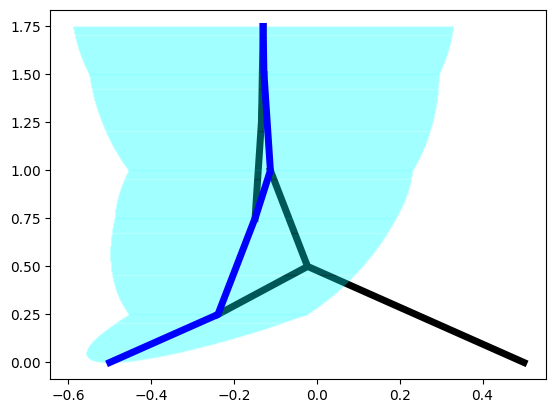

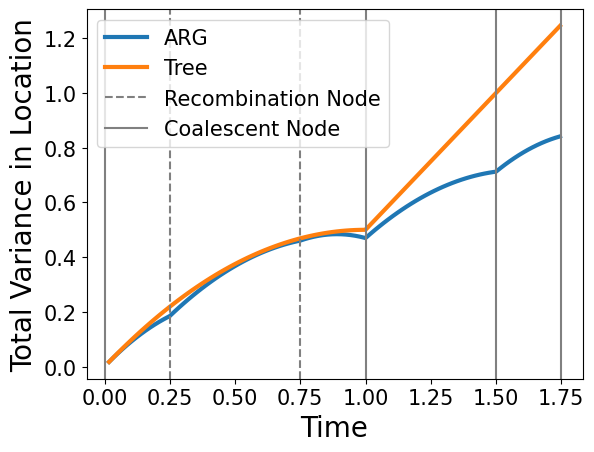

In [22]:
ts = ts_stacked(n=3)
ts_tables = ts.dump_tables() 
ts_edges = ts_tables.edges
ts_edges.left = [250, 0, 0, 0, 500, 250, 0, 250, 750, 500, 0, 500, 750, 0]
ts_nodes = ts_tables.nodes 
ts_nodes.time = [0,0,0.25,0.25,0.5,0.75,0.75,1,1.25,1.25,1.5,1.75]
ts_tables.sort() 
ts = ts_tables.tree_sequence()

ts_tree = ts.keep_intervals( np.array([ts.breakpoints(as_array=True)[1:3]]), simplify=False).trim()
interval = (ts.tables.nodes.time[2] - ts.tables.nodes.time[0])/5000.0

for path in [[3,4],[5,9,10],[8,11],[1,4,7]]:
    intervals = (ts.tables.nodes.time[path[-1]] - ts.tables.nodes.time[path[0]])/interval
    node_times, node_locations, node_variance = track_lineage(ts, path, intervals=intervals)
    plt.plot(np.transpose(node_locations)[0],node_times,color='black',linewidth =5 )
    

path = [0,2,6,7,10,11]
node_times, node_locations, node_variance = track_lineage(ts, path, intervals=1000) 
markers, caps, bars = plt.errorbar(x = np.transpose(node_locations)[0],y = node_times, xerr=0.5*np.sqrt(node_variance), ecolor='cyan',elinewidth=1, color = 'blue',linewidth =5 )
[bar.set_alpha(0.1) for bar in bars]
[cap.set_alpha(0.1) for cap in caps]

plt.show()

ts = ts_stacked(n=3)
ts_tables = ts.dump_tables() 
ts_edges = ts_tables.edges
ts_edges.left = [250, 0, 0, 0, 500, 250, 0, 250, 750, 500, 0, 500, 750, 0]
ts_nodes = ts_tables.nodes 
ts_nodes.time = [0,0,0.25,0.25,0.5,0.75,0.75,1,1.25,1.25,1.5,1.75]
ts_tables.sort() 
ts = ts_tables.tree_sequence()
ts_tree = ts.keep_intervals( np.array([ts.breakpoints(as_array=True)[1:3]]), simplify=False).trim()
path = [0,2,6,7,10,11]
track_single_lineage(ts, ts_tree, path)
